In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from tqdm.notebook import tqdm

from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

from qc_grader.challenges.spring_2022.helpers import generate_XX, generate_YY, generate_disordered_tb_instruction

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
t = Parameter('t')

In [3]:
XX = generate_XX(t)
YY = generate_YY(t)

# 5 site tight-binding lattice

In this exercise we simulate a tight-binding lattice with five sites. First, we look at the tight-binding Hamiltonian with all the site energies at the same value. As a reminder, the Hamiltonian for a 5 site tight-binding lattice is: 

$$H_{\rm tb}/\hbar = J \sum^{3}_{i=0} (X_i X_{i+1} + Y_i Y_{i+1})$$

For this challenge, without loss of generality, we set $\hbar=1$ and $J=1$.

## 1. Particle transport

In a tight-binding system the particle propagation can be described by a continuous-time quantum random walk. Quantum random walks are the quantum mechanical analog of classical random walks. A random walk is the process by which a randomly-moving particle moves away from its starting point. Under a classical random walk, the probability of finding the particle at time $t$ at position $r$ from the starting point follows a Gaussian distribution:
$$ p_{\text{classical}}(r,t) \propto e^{-|r|^2/t} $$

The standard deviation of this probability distribution grows as the square-root with time: $\sigma_{\text{classical}}= \sqrt{t}$. Quantum properties such as single-particle superposition and interference result in a qualitative difference between classical and quantum random walks. Under a quantum random walk, the probability of finding the particle at position $r$ from the starting point follows a [Bessel function of the first kind](https://en.wikipedia.org/wiki/Bessel_function):
$$ p_{\text{quantum}}(r,t) \propto |J_r(2t)|^2 $$

The standard deviation of this probability distribution grows linearly with time: $\sigma_{\text{quantum}} = t$.

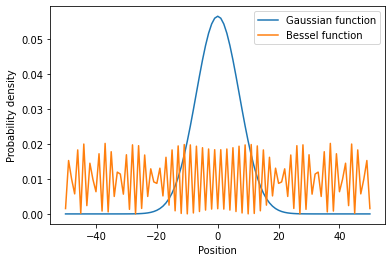

In [4]:
from scipy.special import jv

t_test = 100
r = np.linspace(-50,50,101)
gaussian = np.exp(-r**2/t_test) / np.sum(np.exp(-r**2/t_test))
bessel = np.abs(jv(r,2*t_test))**2 / np.sum(np.abs(jv(r,2*t_test))**2)

plt.figure(facecolor='white')
plt.plot(r, gaussian, label=r'Gaussian function')
plt.plot(r, bessel, label=r'Bessel function')

plt.xlabel('Position')
plt.ylabel('Probability density')
plt.legend()
plt.show()

The spatial propagation of the particle throughout the lattice, relative to its initial location, is quantified by the mean square displacement $⟨x^2⟩= \sum_i p_i x^2_i$, where $p_i$ is the probability of finding the particle on site $i$. A classical random walk propagates diffusively in time with $⟨x^2⟩ \propto t$, whereas a QRW exhibits ballistic propagation with a mean-square displacement $⟨x^2⟩ \propto t^2$. 

The quadratic speed-up of quantum random walks in comparison to classical random walks is analogous to the quadratic speed-up of the Grover search algorithm compared to classical search!

<div class="alert alert-block alert-danger">
    
<b>Challenge question 2a</b> 

Append the XX and YY gates to our circuit to create a trotterize time evolution under the tight-binding Hamiltonian.
    
</div>

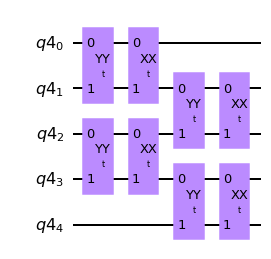

In [5]:
num_qubits = 5 ## DO NOT EDIT

Trot_tb_qr = QuantumRegister(num_qubits)
Trot_tb_qc = QuantumCircuit(Trot_tb_qr, name='Trot')

###EDIT CODE BELOW
for i in range(0, num_qubits-1):
    if i%2 == 0:
        Trot_tb_qc.append(YY, [Trot_tb_qr[i], Trot_tb_qr[i+1]])
        Trot_tb_qc.append(XX, [Trot_tb_qr[i], Trot_tb_qr[i+1]])
for i in range(0, num_qubits-1):
    if i%2 == 1:
        Trot_tb_qc.append(YY, [Trot_tb_qr[i], Trot_tb_qr[i+1]])
        Trot_tb_qc.append(XX, [Trot_tb_qr[i], Trot_tb_qr[i+1]])

###DO NOT EDIT BELOW
Trot_tb_gate = Trot_tb_qc.to_instruction()
Trot_tb_qc.draw()

In [35]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex2a

grade_ex2a(Trot_tb_qc)


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


<div class="alert alert-block alert-danger">
    
<b>Challenge question 2b</b> 

Next, we want to add a particle in the form of an excitation to **qubit 0**. This can be accomplished by applying an  𝑋  gate to flip the state of the qubit from  |0⟩  to  |1⟩  before time evolution under the Hamiltonian.
    
</div>

In [6]:
delta_t=0.15 # DO NOT EDIT
time_steps=np.arange(1,20,1) # DO NOT EDIT

circuits=[]

for n_steps in time_steps:
    
    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr,cr)

    ###EDIT CODE BELOW
    qc.x(0)
    ###DO NOT EDIT BELOW
    
    for _ in range(n_steps):
        qc.append(Trot_tb_gate, [i for i in range(num_qubits)])
        
    qc = qc.bind_parameters({t: delta_t})
    
    circuits.append(qc)

We can track the movement of the particle by keeping track of the probability of finding the excitation on each qubit at different time steps. 

<div class="alert alert-block alert-danger">
    
<b>Challenge question 2c</b> 

First, extract the probabilities of each qubit being in the $|1\rangle$ at different times using the output state from the statevector_simulator.
    
</div>

In [61]:
from qiskit import transpile

# Use Aer's statevector simulator
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_density=[]
for circ in tqdm(circuits):

    transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

    job_sim = backend_sim.run(transpiled_circ)

    # Grab the results from the job.
    result_sim = job_sim.result()
    outputstate = result_sim.get_statevector(transpiled_circ, decimals=5)
    
    ps=[]
    
    ###EDIT CODE BELOW (Extract the probability of finding the excitation on each qubit)
    print(outputstate.probabilities()[1])
    ps.append(outputstate.probabilities()[1])
    ps.append(outputstate.probabilities()[2])
    ps.append(outputstate.probabilities()[4])
    ps.append(outputstate.probabilities()[8])
    ps.append(outputstate.probabilities()[16])
    ###DO NOT EDIT BELOW
    
    probability_density.append(ps)
    
probability_density=np.array(probability_density)

  0%|          | 0/19 [00:00<?, ?it/s]

0.9126745155999999
0.6876389775999999
0.4142724496
0.1846764676
0.0490046769
0.0023078416
0.0049744809
0.0162282121
0.0163763209
0.0075533481
0.0005230369
0.0022155849
0.012523848099999998
0.0285474816
0.0498673561
0.0810597841
0.1316601225
0.21396175360000003
0.33674809000000006


Text(0, 0.5, 'Time (1/J)')

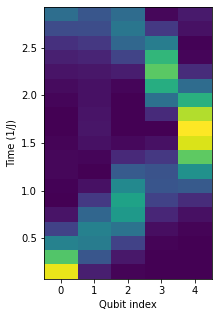

In [8]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t, probability_density)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

In [54]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex2b

grade_ex2b(probability_density)


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


<div class="alert alert-block alert-info">
    
<b>Hardware challenge I</b> 
    
**(This section will not be graded, but take note of the difference between simulation and hardware results.)**

Run the circuits for the quantum random walk on real hardware and extract the probability of finding an excitation on each qubit.
    
</div>

In [9]:
from qiskit.tools.monitor import job_monitor
from qiskit import IBMQ

# Loading your IBM Quantum account
IBMQ.load_account()
IBMQ.providers() # see a list of providers you have access to

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='qc-spring-22-4', group='group-1', project='recmPdBmkX53UV78M')>]

In [10]:
# Get the special provider assigned to you using information from the output above
hub_name = 'qc-spring-22-4' # e.g. 'qc-spring-22-1'
group_name = 'group-1' # e.g. 'group-2'
project_name = 'recmPdBmkX53UV78M' # e.g. 'recPdHH04wfWiNHjG'
provider = IBMQ.get_provider(hub=hub_name, group=group_name, project=project_name)

# Get `ibm_nairobi` backend from the provider
backend_name = 'ibm_nairobi'
backend = provider.get_backend(backend_name)
backend # See details of the `ibm_nairobi` quantum system

<IBMQBackend('ibm_nairobi') from IBMQ(hub='qc-spring-22-4', group='group-1', project='recmPdBmkX53UV78M')>

In [11]:
initial_layout=[0 , 1 , 3 , 5 , 4]

hardware_transpiled_circuits=[]
for circ in circuits:
    
    hardware_circ=deepcopy(circ)
    hardware_circ.barrier()
    hardware_circ.measure(range(num_qubits), range(num_qubits))
    hardware_transpiled_circuits.append(transpile(hardware_circ, backend, initial_layout=initial_layout, optimization_level=3))

In [12]:
shots=1024
job = execute(hardware_transpiled_circuits, backend=backend, shots=shots)
job_monitor(job)
print('Job ID', job.job_id())

Job Status: job has successfully run
Job ID 628f0624558d564dfdc3de47


Text(0, 0.5, 'Time (1/J)')

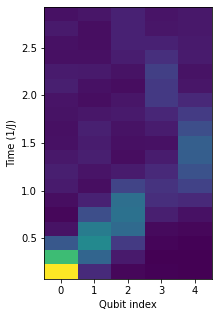

In [94]:
experiment_results=job.result()

probability_density_exp=[]
for output in experiment_results.get_counts():
    ps=[]

    ###EDIT CODE BELOW (Extract the probability of finding the excitation on each qubit)
    for s in ['00001','00010','00100','01000','10000']:
        if output.get(s) == None:
            ps.append(0)
        else:
            p = output.get(s)/shots
            ps.append(p)
    #print(ps)

    ###DO NOT EDIT BELOW
    probability_density_exp.append(ps)

plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t, probability_density_exp)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

## 2. Anderson localization

Particle propagation is significantly impacted by the introduction of disorder in the site energies, leading to Anderson localization. Lattice inhomogeneity causes scattering and leads to quantum interference that tends to inhibit particle propagation, a signature of localization. The wavefunction of a localized particle rapidly decays away from its initial position, effectively confining the particle to a small region of the lattice.

Phillip Anderson first proposed that scattering from disorder can bring transport to a complete halt in 1958 [1]. Before Anderson's discovery, scientists modelled crystal disorders as perturbations that scatter electrons randomly, treating electrons as point-like particles. This logic led to the description of transport in such media as Brownian motion, which underlies Ohm's law. However, Anderson revisited the effect of disorder on the evolution of an electron's wavefunction in an otherwise periodic crystal [2]. Anderson analysed the problem in the quantum regime, thus fundamentally accounting for the wave nature of the electron, and found that the classical diffusive motion of the electron breaks down as the electronic wavefunction becomes exponentially localized, under a broad range of conditions. Hence, when the electron is initially placed on one atom, its wavefunction will no longer expand to cover the whole crystal with time, but it will rather remain localized around its initial position. Thus, the material will cease to conduct charge, and eventually become an insulator. This localization phenomenon is a direct consequence of interference between different paths arising from multiple scattering of the electron by lattice defects.

<div>
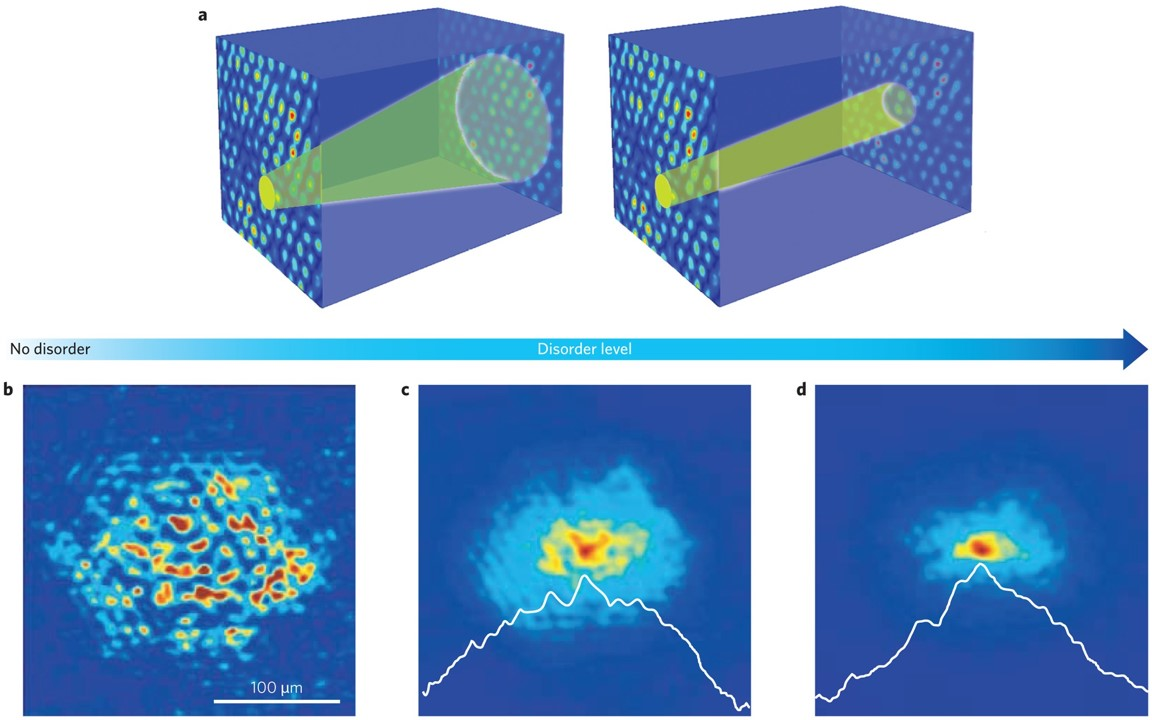
</div> figure from reference [2]

We can study Anderson localization using the tight-binding Hamiltonian. The Hamltonian in the presence of disorder in site energies takes the following form: 
$$H_{\rm tb}/\hbar = \sum^{3}_{i=0} (X_i X_{i+1} + Y_i Y_{i+1}) + \sum_i \epsilon_i Z_i $$

By changing the $\epsilon_i$ values we can imitate disorder by creating an Aubry-Andre (AA) quasicrystal which leads to Anderson localization. In this lattice model, $\epsilon_i=W \rm{cos}(2\pi\beta i)$ where $W$ is the disorder strength, and $\beta$ determines the quasicrystal periodicity.

[1] https://physicstoday.scitation.org/doi/10.1063/1.3206091?feed=most-cited

[2] https://www.nature.com/articles/nphoton.2013.30

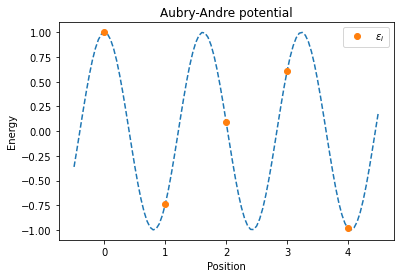

In [96]:
beta=(np.sqrt(5)-1)/2 # DO NOT EDIT
AA_patern=np.cos(2*np.pi*beta*np.arange(num_qubits)) # DO NOT EDIT

plt.plot(np.linspace(-0.5,4.5,101), np.cos(2*np.pi*beta*np.linspace(-0.5,4.5,101)), '--')
plt.plot(np.arange(num_qubits), AA_patern, 'o', label=r'$\epsilon_i$')
plt.xlabel('Position')
plt.ylabel('Energy')
plt.legend()
plt.title('Aubry-Andre potential')
plt.show()

<div class="alert alert-block alert-danger">
    
<b>Challenge question 2d</b> 

Modify each tight-binding trotter step to include an arbitrary phase used to simulate Anderson localization.
    
</div>

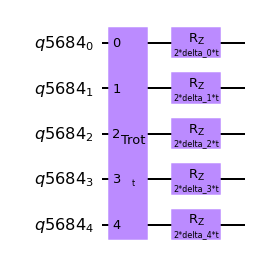

In [97]:
Trot_qr_disorder = QuantumRegister(num_qubits)
Trot_qc_disorder = QuantumCircuit(Trot_qr_disorder, name='Trot disorder')

Trot_qc_disorder.append(Trot_tb_gate,[0,1,2,3,4])
deltas=[Parameter('delta_{:d}'.format(idx)) for idx in range(num_qubits)]

###EDIT CODE BELOW (add a parametric disorder to each qubit)
for i in range(num_qubits):
    Trot_qc_disorder.rz(2*deltas[i]*t,i)

###DO NOT EDIT BELOW
    
# Convert custom quantum circuit into a gate
Trot_disorder_gate = Trot_qc_disorder.to_instruction()

Trot_qc_disorder.draw()

In [98]:
delta_t=0.15
time_steps=np.arange(1,20,1)

W=2 # DO NOT EDIT

disorders=W*AA_patern # DO NOT EDIT

disorder_circuits=[]

for n_steps in time_steps:

    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr, cr)

    qc.x(0)
    
    for _ in range(n_steps):
        qc.append(Trot_disorder_gate, [i for i in range(num_qubits)])

    qc = qc.bind_parameters({t: delta_t})
    qc = qc.bind_parameters({deltas[idx]: disorders[idx] for idx in range(num_qubits)})

    disorder_circuits.append(qc)

<div class="alert alert-block alert-danger">
    
<b>Challenge question 2e</b> 

Finally, extract the probability of finding an excitation on each qubit.
    
</div>

In [99]:
from qiskit import transpile

# Use Aer's statevector simulator
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_density_localization=[]
for circ in tqdm(disorder_circuits):

    transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

    job_sim = backend_sim.run(transpiled_circ)

    # Grab the results from the job.
    result_sim = job_sim.result()
    outputstate = result_sim.get_statevector(transpiled_circ, decimals=5)
    
    ps=[]
    
    ###EDIT CODE BELOW (Extract the probability of finding the excitation on each qubit)
    #print(outputstate.probabilities())
    ps.append(outputstate.probabilities()[1])
    ps.append(outputstate.probabilities()[2])
    ps.append(outputstate.probabilities()[4])
    ps.append(outputstate.probabilities()[8])
    ps.append(outputstate.probabilities()[16])
    ###DO NOT EDIT BELOW
    
    probability_density_localization.append(ps)
    
probability_density_localization=np.array(probability_density_localization)

  0%|          | 0/19 [00:00<?, ?it/s]

Text(0, 0.5, 'Time (1/J)')

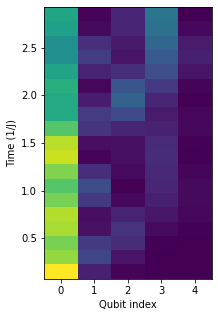

In [100]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t ,probability_density_localization)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

In [101]:
## Grade and submit your solution
from qc_grader.challenges.spring_2022 import grade_ex2c

grade_ex2c(probability_density_localization)


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


<div class="alert alert-block alert-info">
    
<b>Hardware challenge II</b> 

**(This section will not be graded, but take note of the difference between simulation and hardware results.)**    

Run the circuits for the quantum random walk with disorder on real hardware and extract the probability of finding an excitation on each qubit.
    
</div>

In [104]:
from qiskit.tools.monitor import job_monitor

provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='qc-spring-2022', group='group-1', project='project-1')
backend = provider.get_backend('ibm_nairobi')

ibmqfactory.load_account:WARNING:2022-05-26 07:40:20,217: Credentials are already in use. The existing account in the session will be replaced.


Traceback (most recent call last):
  Input In [104] in <cell line: 4>
    provider = IBMQ.get_provider(hub='qc-spring-2022', group='group-1', project='project-1')
  File /opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:423 in get_provider
    raise IBMQProviderError('No provider matches the specified criteria: '
IBMQProviderError: 'No provider matches the specified criteria: hub = qc-spring-2022, group = group-1, project = project-1'

Use %tb to get the full traceback.


In [105]:
initial_layout=[0 , 1 , 3 , 5 , 4]

hardware_transpiled_circuits_disordered=[]
for circ in disorder_circuits:
    
    hardware_circ=deepcopy(circ)
    hardware_circ.barrier()
    hardware_circ.measure(range(num_qubits), range(num_qubits))
    hardware_transpiled_circuits_disordered.append(transpile(hardware_circ, backend, initial_layout=initial_layout, optimization_level=3))

In [106]:
shots=1024
job_disorder = execute(hardware_transpiled_circuits_disordered, backend=backend, shots=shots)
job_monitor(job_disorder)
print('Job ID', job_disorder.job_id())

Job Status: job has successfully run
Job ID 628f2f7b7dd213f67633f6df


Text(0, 0.5, 'Time (1/J)')

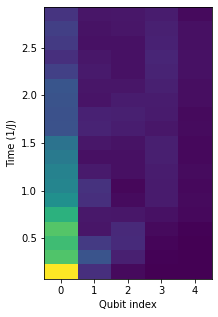

In [111]:
disorder_experiment_results=job_disorder.result()

disorder_probability_density_exp=[]
for output in disorder_experiment_results.get_counts():
    ps=[]
    #print(output.get('00001'))
    ###EDIT CODE BELOW (Extract the probability of finding the excitation on each qubit)
    
    for s in ['00001','00010','00100','01000','10000']:
        if output.get(s) == None:
            ps.append(0)
        else:
            p = output.get(s)/shots
            ps.append(p)
    
    ###DO NOT EDIT BELOW
    
    disorder_probability_density_exp.append(ps)
    
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t, disorder_probability_density_exp)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')